In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


In [ ]:
# %pip install pandas
# %pip install numpy
# %pip install matplotlib
# %pip install seaborn


# Test dependency detection

In [ ]:
from os import listdir
from os.path import isfile, join
# AST result repository
file_directory = "/work/nabhan-s/output/commit/temp-commit/commit_info_consul_k8s/consul-k8s"
# dependency output location
result_path = Path('/work/nabhan-s/output/commit/dependency-output/out_consul_k8s.csv')
files = [f for f in listdir(file_directory) if not f.endswith("_error.csv")]
error_file = [f for f in listdir(file_directory) if f.endswith("_error.csv")]

files

In [ ]:
temp_list = []

for file in error_file:
    temp = pd.read_csv(file_directory + "/" + file)
    for line in temp.iterrows():
        if "no buildable Go source files" not in line[1]["error_message"] and line[1]["package_path"]:
            temp_list.append(line[1])

error_package = pd.DataFrame(temp_list)
error_package["repo_name"] = error_package["package_path"].apply(lambda x: x.split("/")[4])
error_package

In [ ]:
df = pd.DataFrame()

for file in files:
    temp = pd.read_csv(file_directory + "/" + file)
    temp['contain_terratest'] = temp['contain_terratest'].astype(bool)
    repo_name = file.split(".")[0].split("_")[0]
    if repo_name == "terratest":
        continue
    # if repo_name in error_repo_name:
    #     pass
    temp['repo_name'] = repo_name
    df = pd.concat([df, temp], ignore_index=True)
# df['contain_terratest'] = df['contain_terratest'].astype(bool)
# repo_name = "awsweeper"
# df['repo_name'] = repo_name

In [ ]:
class Dependency:
    func_name: str
    package_name: str

    def __init__(self, func_name, package_name, previous_func=None, pos=None):
        self.func_name = func_name
        self.package_name = package_name
        self.previous_func = previous_func
        self.pos = pos

    def __eq__(self, other):
        return self.func_name == other.func_name and self.package_name == other.package_name

    def __str__(self):
        if self.previous_func is None:
            return self.func_name + " " + self.package_name
        else:
            return self.func_name + " " + self.package_name + " " + self.previous_func

def find_repo_with_test_cases(temp_df):
    repo_dict = {}
    for i in temp_df.iterrows():
        if type(i[1]['func_decl_name']) == float:
            continue
        if i[1]['func_decl_name'].startswith('Test') or i[1]['func_decl_name'] == 'Describe':
            node = Dependency(i[1]['func_decl_name'], i[1]['package_name'], pos=i[1]['pos'])
            if i[1]['repo_name'] not in repo_dict:
                repo_dict[i[1]['repo_name']] = [node]
            elif node not in repo_dict[i[1]['repo_name']]:
                repo_dict[i[1]['repo_name']].append(node)
    return repo_dict

In [ ]:
from queue import Queue

# Find chain dependency with function call
def find_chain_dependency(repo_df, current_func_name, package_name, repo_name, pos):
    func_df = pd.DataFrame()
    adj_list = Queue()
    for dependency in find_called_func(repo_df, current_func_name, package_name, pos):
        adj_list.put(dependency)
    travelled_list = []
    while not adj_list.empty():
        node = adj_list.get()
        node_func_name = node.func_name
        node_package_name = node.package_name
        if node not in travelled_list:
            temp_df = pd.DataFrame([[repo_name, node_func_name, node_package_name]], columns=['repo_name', 'func_name', 'package_name'])
            func_df = pd.concat([func_df, temp_df], ignore_index=True)
            if repo_name in node_package_name or not 'github' in node_package_name:
                for next_node in find_called_func(repo_df, node_func_name, node_package_name, None):
                    next_node.previous_func = node_func_name
                    adj_list.put(next_node)
            travelled_list.append(node)
    return func_df


def find_called_func(repo_df, func_name, package_name, pos):
    dependency_list = []
    if pos is not None:
        temp_df = repo_df[(repo_df['func_decl_name'] == func_name) & (repo_df['package_name'] == (package_name.split("/")[-1])) & (repo_df['pos'] == pos)]
    else:
        temp_df = repo_df[(repo_df['func_decl_name'] == func_name) & (repo_df['package_name'] == (package_name.split("/")[-1]))]
    for i in temp_df.iterrows():
        dependency_list.append(Dependency(i[1]['func_name'], i[1]['module_path']))

    return dependency_list

def swap_columns(df, col1, col2):
    col_list = list(df.columns)
    x, y = col_list.index(col1), col_list.index(col2)
    col_list[y], col_list[x] = col_list[x], col_list[y]
    df = df[col_list]
    return df

def detect_dependency_df(inpt):
    repo_df = inpt[0]
    func_name = inpt[1]
    package_name = inpt[2]
    repo_name = inpt[3]
    pos = inpt[4]
    result = find_chain_dependency(repo_df, func_name, package_name, repo_name, pos)
    result['func_decl_name'] = func_name
    result['func_decl_package_name'] = package_name
    result['pos'] = pos
    result = swap_columns(result, 'func_decl_name', 'func_name')
    result = swap_columns(result, 'func_decl_package_name', 'package_name')
    return result

In [ ]:
from pathlib import Path
import multiprocessing as mp
input_list = []
result = pd.DataFrame()

repo_list = pd.DataFrame([file.split('_')[0] for file in files])
repo_list.drop_duplicates(inplace=True)
repo_list
for i, repo in repo_list.iterrows():
    file_list = [f for f in listdir(file_directory) if (not f.endswith("_error.csv")) and (f.startswith(repo[0]))]
    repo_df = pd.DataFrame()
    for file in file_list:
        temp_df = pd.read_csv(file_directory + '/' + file)
        temp_df['contain_terratest'] = temp_df['contain_terratest'].astype(bool)
        repo_name = file.split(".")[0].split("_")[0]
        temp_df['repo_name'] = repo_name
        repo_df = pd.concat([repo_df, temp_df], ignore_index=True)
    repo_name_with_test = find_repo_with_test_cases(repo_df)
    if repo[0] in repo_name_with_test:
        for func in repo_name_with_test[repo[0]]:
            input_list.append([repo_df, func.func_name, func.package_name, repo[0], func.pos])
    else:
        print(repo[0] + " does not have test cases")
    detect_dependency_df(input_list[0])
    with mp.Pool(50) as pool:
        result = pool.map(detect_dependency_df, input_list)
    result = pd.concat(result, ignore_index=True)
    result.to_csv(result_path)
    print(repo[0] + " is done")

# ------------------------------------------------------------------------------------------------------------------------------------------------------

In [ ]:
df.groupby('repo_name').size()

In [ ]:
temp_df = pd.read_csv('/home/nabhan-s/repo_analyze_list.csv')
temp_df['repo_name'] = temp_df['repo_name'].str.replace('/','---')
temp_df['repo_name']

In [ ]:
df[(df['func_decl_name'].str.startswith("Test", na=False)) | (df['func_decl_name'] == 'Describe')].groupby('repo_name').size()

In [ ]:
count_series = df[(df['func_decl_name'].str.startswith("Test")) & (df['file_name'].str.endswith("_test.go"))].groupby(['repo_name','func_decl_name']).size()
count_series

In [ ]:
new_count_df = count_series.to_frame(name = 'size').reset_index()
new_count_df.groupby('repo_name').size().sum()

In [ ]:
temp = df[(df['func_decl_name'].str.startswith("Test")) & ~(df['file_name'].str.endswith("_test.go"))].groupby(['repo_name','func_decl_name']).size()

In [ ]:
temp_count_series = temp.to_frame(name = 'size').reset_index()
temp_count_series.groupby('repo_name').size().sum()

In [ ]:
[(df.iloc[i, 0], df.iloc[i, 1], df.iloc[i, 2], df.iloc[i, 3]) for i,j in zip(*np.where(pd.isnull(df)))]

In [ ]:
def find_default_test_cases(df):
    test_cases = {}
    for i in range(len(df)):
        if df['func_decl_name'][i].startswith('Test') and df["package_name"][i] == 'test':
            if df['func_decl_name'][i] not in test_cases:
                test_cases[df['func_decl_name'][i]] = df['contain_terratest'][i]
            elif df['contain_terratest'][i]:
                test_cases[df['func_decl_name'][i]] = df['contain_terratest'][i]
    return test_cases

In [ ]:
df.loc[(df['func_decl_name'].str.startswith('Test', na=True)) & (df['repo_name'] == 'bank-vaults')]['func_decl_name'].value_counts()

# Test cases with terratest percentage

In [2]:
# Repository dependency data that store in csv format
new_df = pd.read_csv('')
new_df['contain_terratest'] = new_df['package_name'].str.contains('github.com/gruntwork-io/terratest')
new_df = new_df[new_df['repo_name'] != 'gruntwork-io---terratest']

terratest_integration_func = pd.read_csv('terratest_integration_func.csv')
terratest_func_list = []

for i, row in terratest_integration_func.iterrows():
    terratest_func_list.append((row['func_name'], row['package_name']))
new_df['is_integrate'] = new_df.apply(lambda row: ((row['func_name'], row['package_name']) in terratest_func_list) or (row['package_name'] in ['github.com/gruntwork-io/terratest/modules/azure', 'github.com/gruntwork-io/terratest/modules/gcp', 'github.com/gruntwork-io/terratest/modules/aws']), axis=1)

new_df['is_helm'] = new_df['package_name'].str.contains('github.com/gruntwork-io/terratest/modules/helm')
new_df['is_aws'] = new_df['package_name'].str.contains('github.com/gruntwork-io/terratest/modules/aws')
new_df['is_gcp'] = new_df['package_name'].str.contains('github.com/gruntwork-io/terratest/modules/gcp')
new_df['is_azure'] = new_df['package_name'].str.contains('github.com/gruntwork-io/terratest/modules/azure')
new_df['is_terraform'] = new_df['package_name'].str.contains('github.com/gruntwork-io/terratest/modules/terraform')
new_df['is_k8s'] = new_df['package_name'].str.contains('github.com/gruntwork-io/terratest/modules/k8s')
new_df['is_docker'] = new_df['package_name'].str.contains('github.com/gruntwork-io/terratest/modules/docker')
new_df['is_packer'] = new_df['package_name'].str.contains('github.com/gruntwork-io/terratest/modules/packer')

repo_with_func_and_count_terratest = new_df.groupby(['repo_name', 'func_decl_name', 'pos']).agg({'is_integrate':'sum' ,'contain_terratest':'sum', 'is_aws':'sum', 'is_gcp':'sum', 'is_azure':'sum', 'is_terraform':'sum', 'is_k8s':'sum', 'is_docker':'sum', 'is_packer':'sum', 'is_helm':'sum'}).reset_index()

In [3]:
remove_list = []
result_df = pd.DataFrame()

for name, group in new_df.groupby(['repo_name', 'func_decl_name', 'pos']):
    if (group['func_name'] == "Describe").any() and name[1] == "Describe":
        remove_list.append((name[0], name[1], name[2]))
        

repo_with_func_and_count_terratest = repo_with_func_and_count_terratest[~repo_with_func_and_count_terratest[['repo_name', 'func_decl_name', 'pos']].apply(tuple,1).isin(remove_list)]
result_df["num_test"] = repo_with_func_and_count_terratest.groupby('repo_name').size()
result_df["num_test"] = repo_with_func_and_count_terratest[repo_with_func_and_count_terratest['func_decl_name'].str.startswith('Test')
    # | (repo_with_func_and_count_terratest['func_decl_name'] == 'Describe')
].groupby('repo_name').size()


In [10]:
result_df.index.to_list()

['absaoss---k8gb',
 'actions-runner-controller---actions-runner-controller',
 'aiven---terraform-provider-aiven',
 'appuio---charts',
 'aztfmod---rovergo',
 'azure---terraform-azurerm-lz-vending',
 'banzaicloud---bank-vaults',
 'banzaicloud---kafka-operator',
 'camunda---camunda-platform-helm',
 'castai---terraform-provider-castai',
 'ccremer---kubernetes-zfs-provisioner',
 'chanzuckerberg---happy',
 'citrix---terraform-provider-adc',
 'citrix---terraform-provider-citrixadc',
 'cloudposse---terraform-provider-utils',
 'cockroachdb---helm-charts',
 'defenseunicorns---zarf-package-software-factory',
 'edgio---terraform-provider-edgecast',
 'equinix---terraform-provider-equinix',
 'estahn---k8s-image-swapper',
 'googlecloudplatform---anthos-samples',
 'googlecloudplatform---cloud-foundation-toolkit',
 'googlecloudplatform---terraform-google-cloud-armor',
 'googleforgames---agones',
 'gruntwork-io---cloud-nuke',
 'gruntwork-io---go-commons',
 'gruntwork-io---kubergrunt',
 'gruntwork-io---t

In [7]:
print(result_df.median())
result_df.describe()

num_test    57.5
dtype: float64


,num_test
count,58.000000
mean,144.224138
std,206.004602
min,1.000000
25%,14.250000
50%,57.500000
75%,178.750000
max,864.000000


In [14]:
temp_result_df = result_df.copy()
temp_result_df = temp_result_df.reset_index()
# temp_result_df.to_csv('repo_with_test_count.csv')

In [30]:
result_df["num_test_terratest"] = repo_with_func_and_count_terratest[repo_with_func_and_count_terratest['contain_terratest'] > 0].groupby('repo_name').size()

result_df["num_integration_test"] = repo_with_func_and_count_terratest[repo_with_func_and_count_terratest['is_integrate'] > 0].groupby('repo_name').size()

result_df['num_helm'] = repo_with_func_and_count_terratest[repo_with_func_and_count_terratest['is_helm'] > 0].groupby('repo_name').size()
result_df["num_aws"] = repo_with_func_and_count_terratest[repo_with_func_and_count_terratest['is_aws'] > 0].groupby('repo_name').size()
result_df["num_gcp"] = repo_with_func_and_count_terratest[repo_with_func_and_count_terratest['is_gcp'] > 0].groupby('repo_name').size()
result_df["num_azure"] = repo_with_func_and_count_terratest[repo_with_func_and_count_terratest['is_azure'] > 0].groupby('repo_name').size()
result_df["num_terraform"] = repo_with_func_and_count_terratest[repo_with_func_and_count_terratest['is_terraform'] > 0].groupby('repo_name').size()
result_df["num_k8s"] = repo_with_func_and_count_terratest[repo_with_func_and_count_terratest['is_k8s'] > 0].groupby('repo_name').size()
result_df["num_docker"] = repo_with_func_and_count_terratest[repo_with_func_and_count_terratest['is_docker'] > 0].groupby('repo_name').size()
result_df["num_packer"] = repo_with_func_and_count_terratest[repo_with_func_and_count_terratest['is_packer'] > 0].groupby('repo_name').size()
# result_df = result_df[result_df['repo_name'] != 'terratest']

result_df = result_df.fillna(0)

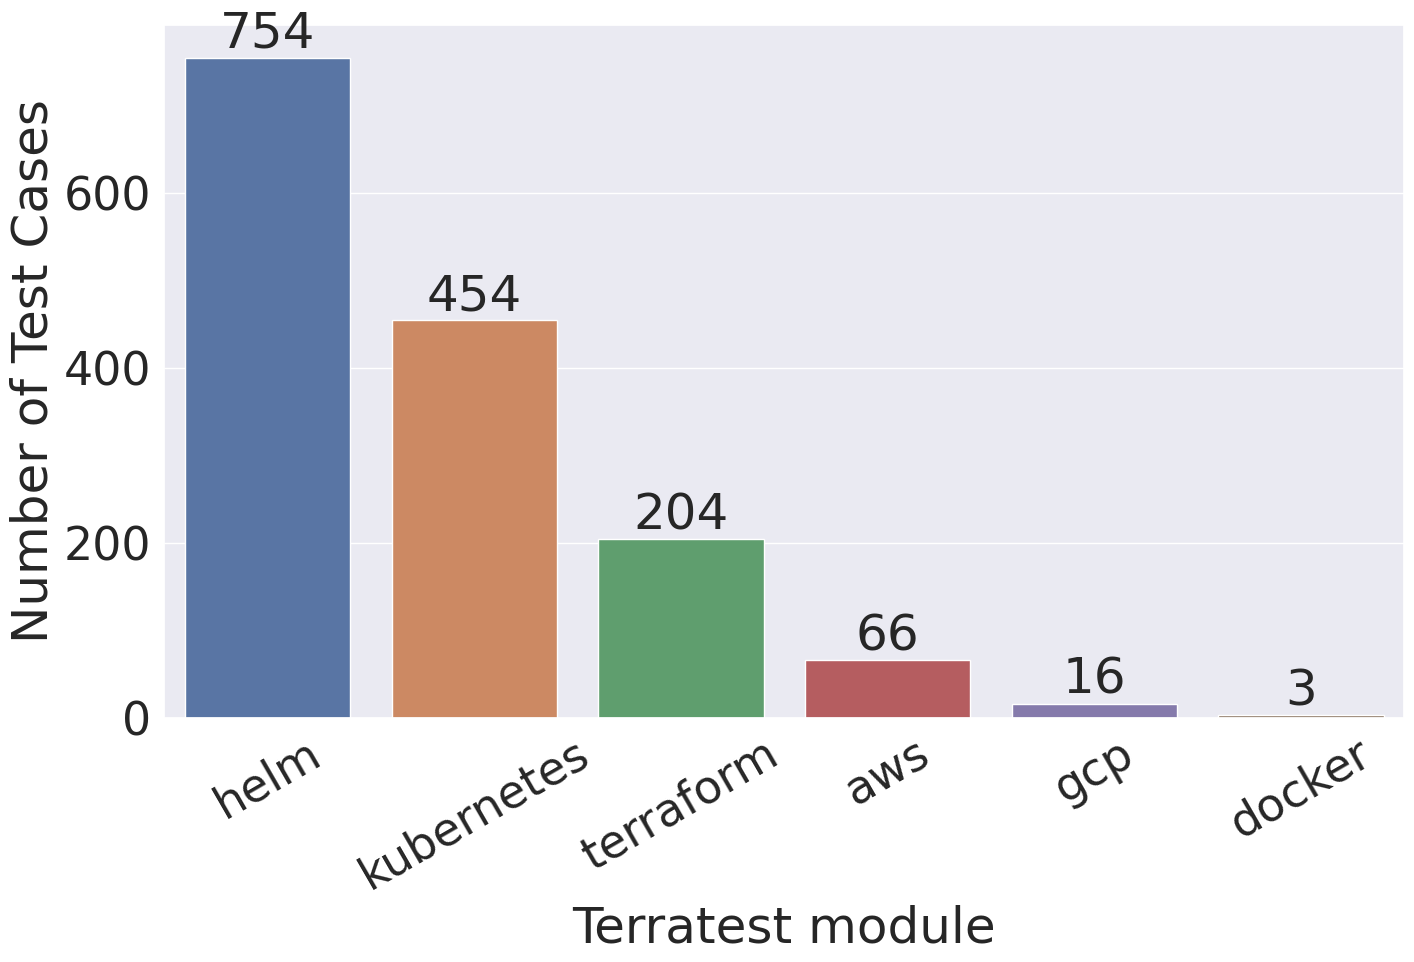

In [147]:
test_cases_df = pd.DataFrame(columns=['module', 'num_test'])
temp_df = pd.DataFrame([["helm", result_df['num_helm'].sum()]], columns=['module', 'num_test'])
test_cases_df = pd.concat([test_cases_df, temp_df], ignore_index=True)
temp_df = pd.DataFrame([["kubernetes", result_df['num_k8s'].sum()]], columns=['module', 'num_test'])
test_cases_df = pd.concat([test_cases_df, temp_df], ignore_index=True)
temp_df = pd.DataFrame([["terraform", result_df['num_terraform'].sum()]], columns=['module', 'num_test'])
test_cases_df = pd.concat([test_cases_df, temp_df], ignore_index=True)
temp_df = pd.DataFrame([["gcp", result_df['num_gcp'].sum()]], columns=['module', 'num_test'])
test_cases_df = pd.concat([test_cases_df, temp_df], ignore_index=True)
temp_df = pd.DataFrame([["docker", result_df['num_docker'].sum()]], columns=['module', 'num_test'])
test_cases_df = pd.concat([test_cases_df, temp_df], ignore_index=True)
temp_df = pd.DataFrame([["aws", result_df['num_aws'].sum()]], columns=['module', 'num_test'])
test_cases_df = pd.concat([test_cases_df, temp_df], ignore_index=True)
test_cases_df = test_cases_df.set_index('module')
test_cases_df = test_cases_df.sort_values(by=['num_test'], ascending=False)

sns.set(font_scale=3)
plt.figure(figsize=(16,9))
ax = sns.barplot(x=test_cases_df.index, y=test_cases_df['num_test'])
ax.bar_label(ax.containers[0])
ax.set(xlabel="Terratest module", ylabel='Number of Test Cases')
ax.set_xticklabels(ax.get_xticklabels(),rotation=30)
plt.savefig('/home/nabhan-s/plot/count_test_cases.pdf', format='pdf', bbox_inches='tight')

In [87]:
count_repo_df = pd.DataFrame(columns=['module', 'num_repo'])

temp_df = pd.DataFrame([["helm", result_df[result_df['num_helm'] > 0]['num_helm'].count()]], columns=['module', 'num_repo'])
count_repo_df = pd.concat([count_repo_df, temp_df], ignore_index=True)
temp_df = pd.DataFrame([["kubernetes", result_df[result_df['num_k8s'] > 0]['num_k8s'].count()]], columns=['module', 'num_repo'])
count_repo_df = pd.concat([count_repo_df, temp_df], ignore_index=True)
temp_df = pd.DataFrame([["gcp", result_df[result_df['num_gcp'] > 0]['num_gcp'].count()]], columns=['module', 'num_repo'])
count_repo_df = pd.concat([count_repo_df, temp_df], ignore_index=True)
temp_df = pd.DataFrame([["aws", result_df[result_df['num_aws'] > 0]['num_aws'].count()]], columns=['module', 'num_repo'])
count_repo_df = pd.concat([count_repo_df, temp_df], ignore_index=True)
temp_df = pd.DataFrame([["azure", result_df[result_df['num_azure'] > 0]['num_azure'].count()]], columns=['module', 'num_repo'])
count_repo_df = pd.concat([count_repo_df, temp_df], ignore_index=True)
temp_df = pd.DataFrame([["terraform", result_df[result_df['num_terraform'] > 0]['num_terraform'].count()]], columns=['module', 'num_repo'])
count_repo_df = pd.concat([count_repo_df, temp_df], ignore_index=True)
temp_df = pd.DataFrame([["docker", result_df[result_df['num_docker'] > 0]['num_docker'].count()]], columns=['module', 'num_repo'])
count_repo_df = pd.concat([count_repo_df, temp_df], ignore_index=True)
temp_df = pd.DataFrame([["packer", result_df[result_df['num_packer'] > 0]['num_packer'].count()]], columns=['module', 'num_repo'])
count_repo_df = pd.concat([count_repo_df, temp_df], ignore_index=True)
count_repo_df = count_repo_df.set_index('module')
count_repo_df = count_repo_df.sort_values(by=['num_repo'], ascending=False)

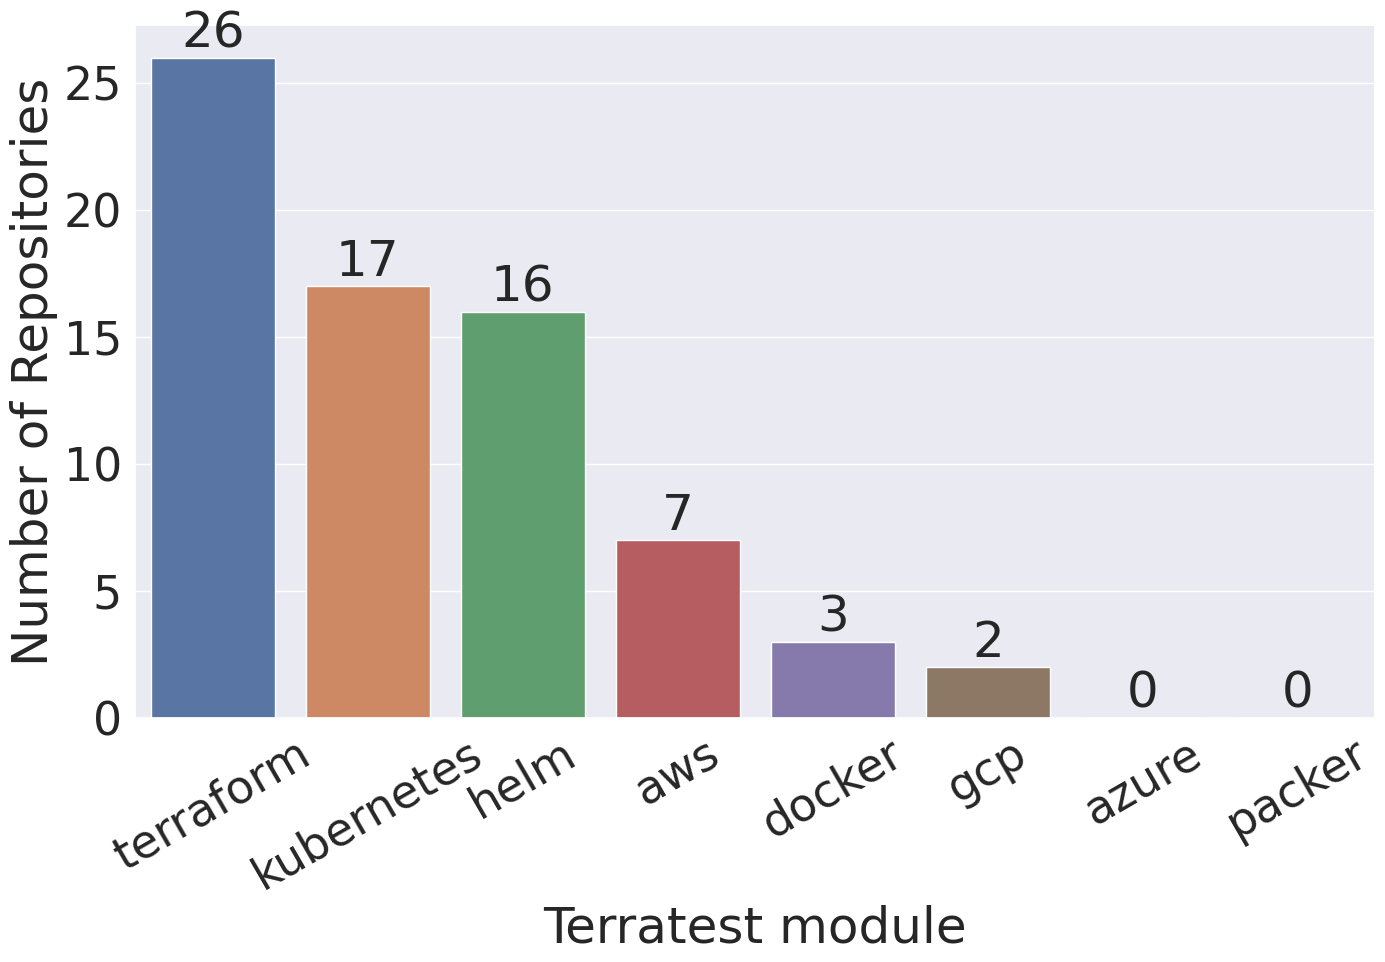

In [146]:
sns.set(font_scale=3)
plt.figure(figsize=(16,9))
ax = sns.barplot(x=count_repo_df.index, y=count_repo_df['num_repo'])
ax.bar_label(ax.containers[0])
ax.set(xlabel="Terratest module", ylabel='Number of Repositories')
ax.set_xticklabels(ax.get_xticklabels(),rotation=30)
plt.savefig('/home/nabhan-s/plot/count_repositories.pdf', format='pdf', bbox_inches='tight')

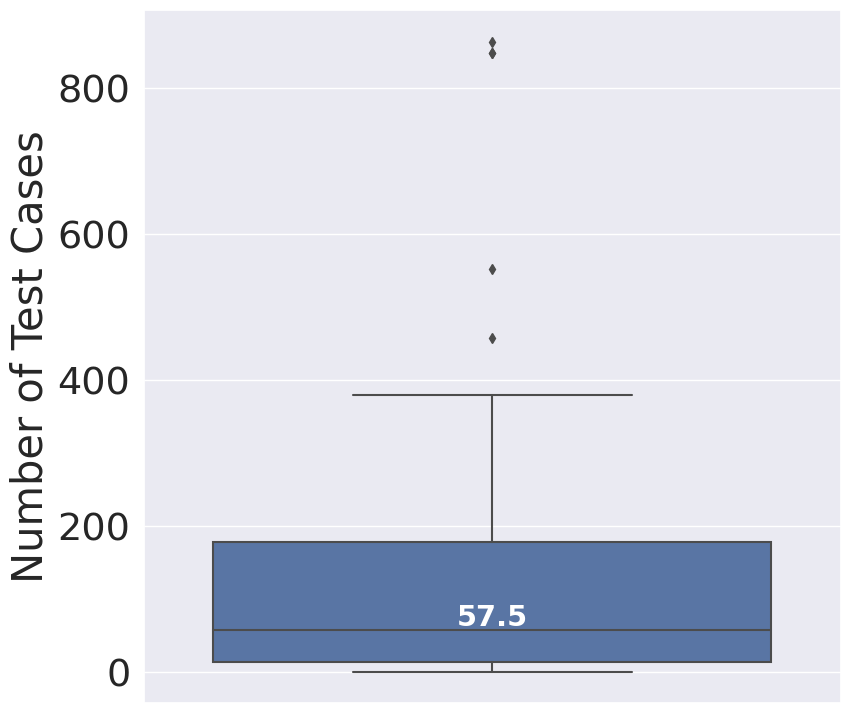

In [155]:

# plot = result_df.boxplot(column=['num_test'], showmeans=True)
sns.set(font_scale=2.5)
plt.figure(figsize=(9,9))
box_plot = sns.boxplot(y='num_test', data=result_df)
box_plot.set(ylabel='Number of Test Cases')
median = result_df['num_test'].median()
vertical_offset = median * 0.1
for xtick in box_plot.get_xticks():
    box_plot.text(xtick,median + vertical_offset,median, 
            horizontalalignment='center',size='x-small',color='w',weight='semibold')
plt.savefig('/home/nabhan-s/plot/rq1_num_test.pdf', format='pdf', bbox_inches='tight')

In [30]:
result_df['num_test'].median()

57.5

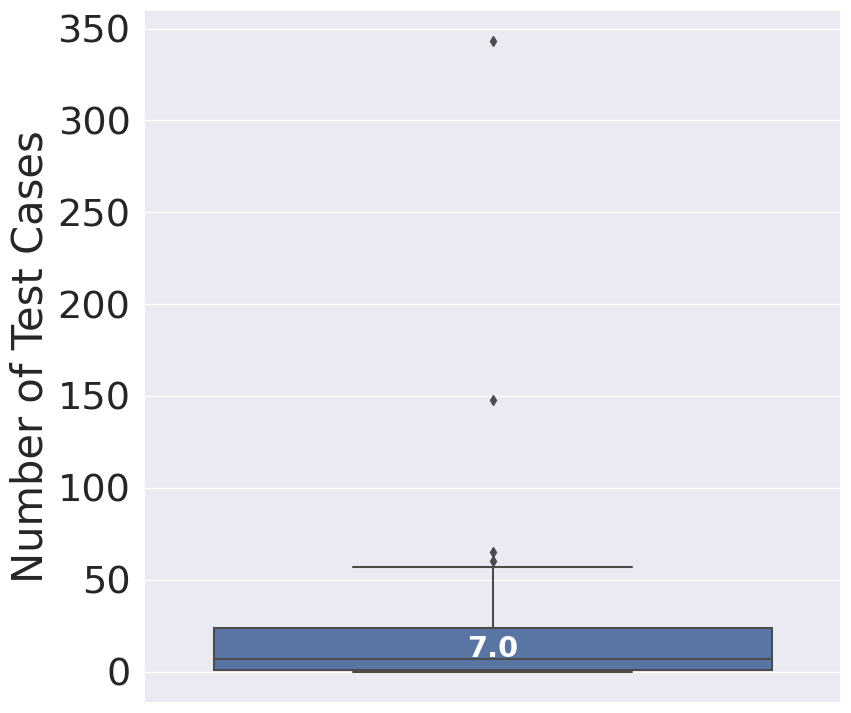

In [156]:
# plot = result_df.boxplot(column=['num_test_terratest'], showmeans=True)
sns.set(font_scale=2.5)
plt.figure(figsize=(9,9))
box_plot = sns.boxplot(y='num_test_terratest', data=result_df)
median = result_df['num_test_terratest'].median()
box_plot.set(ylabel='Number of Test Cases')
vertical_offset = median * 0.1
for xtick in box_plot.get_xticks():
    box_plot.text(xtick,median + vertical_offset,median, 
            horizontalalignment='center',size='x-small',color='w',weight='semibold')
plt.savefig('/home/nabhan-s/plot/rq1_num_test_terratest.pdf', format='pdf', bbox_inches='tight')

In [31]:
result_df['num_test_terratest'].median()

7.0

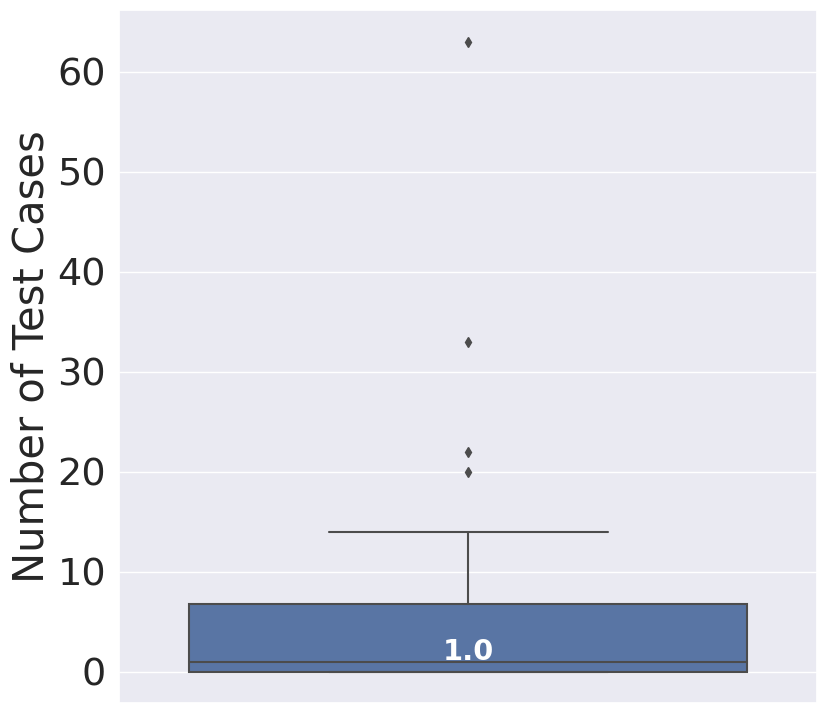

In [157]:
# result_df.boxplot(column=['num_integration_test'])
sns.set(font_scale=2.5)
plt.figure(figsize=(9,9))
box_plot = sns.boxplot(y='num_integration_test', data=result_df)
median = result_df['num_integration_test'].median()
box_plot.set(ylabel='Number of Test Cases')
vertical_offset = median * 0.1
for xtick in box_plot.get_xticks():
    box_plot.text(xtick,median + vertical_offset,median, 
            horizontalalignment='center',size='x-small',color='w',weight='semibold')
plt.savefig('/home/nabhan-s/plot/rq1_num_integration_test.pdf', format='pdf', bbox_inches='tight')

In [32]:
result_df['num_integration_test'].median()

1.0

In [98]:
result_df['num_test'].sum()

8365

In [97]:
result_df['num_test_terratest'].sum()

1215.0

In [96]:
result_df['num_integration_test'].sum()

297.0

In [95]:
result_df['num_aws'].sum()

66.0

In [94]:
result_df['num_gcp'].sum()

16.0

In [93]:
result_df['num_azure'].sum()

0.0

In [92]:
result_df['num_terraform'].sum()

204.0

In [91]:
result_df['num_k8s'].sum()

454.0

In [90]:
result_df['num_docker'].sum()

3.0

In [89]:
result_df['num_packer'].sum()

0.0

# Detect Test Cases

In [68]:
detect_test = repo_with_func_and_count_terratest[repo_with_func_and_count_terratest['contain_terratest'] > 0]
detect_test = detect_test[['repo_name', 'func_decl_name', 'pos']]
detect_test = detect_test.drop_duplicates()
detect_test

,repo_name,func_decl_name,pos
14,absaoss---k8gb,TestEmptyDNSList,204388
15,absaoss---k8gb,TestEmptyEdgeDNS,204194
16,absaoss---k8gb,TestEmptyEdgeDNSInTheList,205415
17,absaoss---k8gb,TestEmptyFQDNButValidEdgeDNS,203942
31,absaoss---k8gb,TestFailoverPlayground,13720
...,...,...,...
8368,yugabyte---terraform-aws-yugabyte,TestYugaByteAwsTerraform,602
8369,zitadel---zitadel-charts,TestWithInlineSecrets,11984
8370,zitadel---zitadel-charts,TestWithMachineKey,13660
8371,zitadel---zitadel-charts,TestWithReferencedSecrets,12484


In [112]:
from os import listdir

def get_df_from_repo_name(repo_name):
    file_directory = "/home/nabhan-s/repo-output"
    file_list = [f for f in listdir(file_directory) if not f.endswith("_error.csv")]
    
    result_df = pd.DataFrame()
    for file in file_list:
        if repo_name in file:
            temp_df = pd.read_csv(file_directory + "/" + file)
            result_df = pd.concat([result_df, temp_df])
    return result_df


def my_join(input_list):
    if len(input_list) == 0:
        return ""
    if len(input_list) == 1:
        return input_list[0]
    else:
        return " ".join(input_list)

In [126]:
grouped_repo_test = detect_test.groupby('repo_name')

repo_test = pd.DataFrame()
repo_commit_hash = pd.read_csv('/home/nabhan-s/commit_hash.csv')
for name, group in grouped_repo_test:
    temp = get_df_from_repo_name(name)
    temp = temp[['file_name', 'package_name', 'func_decl_name', 'pos']]
    temp = temp.drop_duplicates()
    temp['repo_name'] = name
    new_df = pd.merge(group, temp, on=['repo_name', 'func_decl_name', 'pos'], how='left')
    new_df = pd.merge(new_df, repo_commit_hash, on=['repo_name'], how='left')
    repo_test = pd.concat([repo_test, new_df], ignore_index=True)
    
repo_test = repo_test.drop_duplicates()
repo_test['github_path'] = list(repo_test['file_name'].str.split('/'))
repo_test['github_path'] = list(repo_test['github_path'].str[1:])
repo_test['github_path'] = 'github.com/' + repo_test['repo_name'].str.replace("---", "/") + "/tree/" + repo_test['commit_sha'] + "/" + repo_test['github_path'].apply(lambda x: '/'.join(x))
repo_test.to_csv('/home/nabhan-s/repo_test_data_set.csv', index=False)